# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

## Init

In [761]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense

# visualization lib
import matplotlib.pyplot as plt

import seaborn as sns

from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

import shap

import eli5
from eli5.sklearn import PermutationImportance

In [762]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [763]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

def show_pred(y_test, y_pred, xlabel, ylabel):
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, y_test)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def show_feature_importances(model, X, y):
    model_name = type(model).__name__
    importances = None

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_       
    else:
        r = permutation_importance(model, X, y, n_repeats=5, random_state=42, n_jobs=4)
        importances = r.importances_std

    sorted_idx = importances.argsort()

    plt.figure(figsize=(8,6)) 
    plt.barh(X.columns[sorted_idx], importances[sorted_idx])
    plt.xlabel(f"{model_name} - Feature Importance")
    plt.show()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:    
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [764]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

## Load Data

In [765]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [766]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,CLEAR BEER,TANK,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01002,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
2,01003,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085
3,01005,CLEAR BEER,KEG,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,4930.067934,4515.50,NaN,NaN,NaN,NaN,4459.9005
4,01010,CLEAR BEER,KEG ONE WAY,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,46.150597,7.15,NaN,NaN,NaN,NaN,40.8850


In [767]:
data = reduce_mem_usage(data)
data['SalesHl'] = data['SalesHl'].astype(np.float64)

Mem. usage decreased to  1.60 Mb (62.1% reduction)


In [768]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  object 
 1   ProductGroup      25002 non-null  object 
 2   PrimaryPack       25002 non-null  object 
 3   Country           25002 non-null  object 
 4   Year              25002 non-null  int16  
 5   Week              25002 non-null  int8   
 6   NumberWorkdays    25002 non-null  int8   
 7   AvgTemp           25002 non-null  float16
 8   PrevWeekAvgTemp   24267 non-null  float16
 9   AvgRain           25002 non-null  float16
 10  PrevWeekAvgRain   24267 non-null  float16
 11  AvgSun            25002 non-null  float16
 12  PrevWeekAvgSun    24267 non-null  float16
 13  IsLockdown        25002 non-null  bool   
 14  PdtHl             479 non-null    float16
 15  PrevWeekPdtHl1    475 non-null    float16
 16  BgtHl             20233 non-null  float1

In [769]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,25002.000000,25002.000000,25002.000000,2.500200e+04,2.426700e+04,25002.000000,24267.000000,2.500200e+04,2.426700e+04,479.000000,475.000000,2.023300e+04,25002.000000,24267.00000,24034.0000,18157.00000,13406.0000,2.316100e+04
mean,2018.157387,25.786497,4.787257,inf,inf,1.674805,1.665039,inf,inf,32.312500,32.531250,inf,620.625288,inf,inf,inf,inf,inf
std,1.530272,15.039761,0.494658,7.718750e+00,7.742188e+00,1.648438,1.632812,2.984375e+00,2.996094e+00,inf,inf,inf,1473.291909,inf,inf,inf,inf,inf
min,2016.000000,1.000000,2.000000,-8.281250e+00,-8.281250e+00,0.000000,0.000000,1.428223e-01,1.428223e-01,0.300049,0.300049,2.512932e-04,0.000000,0.00000,0.0000,0.00000,0.0000,5.319214e-02
25%,2017.000000,13.000000,5.000000,4.000000e+00,3.478516e+00,0.471436,0.471436,2.164062e+00,2.164062e+00,3.046875,3.068359,5.840625e+01,30.000000,33.59375,34.1875,45.90625,50.6875,4.000000e+01
50%,2018.000000,25.000000,5.000000,1.017969e+01,1.017969e+01,1.142578,1.142578,4.707031e+00,4.707031e+00,13.039062,13.125000,2.145000e+02,121.187500,129.87500,131.7500,172.50000,194.7500,1.505000e+02
75%,2019.000000,39.000000,5.000000,1.770312e+01,1.776562e+01,2.365234,2.306641,7.136719e+00,7.136719e+00,33.843750,33.843750,6.585000e+02,486.250000,502.50000,507.2500,595.50000,624.5000,5.335000e+02
max,2021.000000,53.000000,5.000000,2.581250e+01,2.581250e+01,7.957031,7.957031,1.386719e+01,1.386719e+01,318.750000,318.750000,1.437600e+04,17824.000000,17824.00000,17824.0000,17824.00000,17824.0000,1.504800e+04


## Missing Values

In [770]:
data.isna().sum()

SkuShort            0    
ProductGroup        0    
PrimaryPack         0    
Country             0    
Year                0    
Week                0    
NumberWorkdays      0    
AvgTemp             0    
PrevWeekAvgTemp     735  
AvgRain             0    
PrevWeekAvgRain     735  
AvgSun              0    
PrevWeekAvgSun      735  
IsLockdown          0    
PdtHl               24523
PrevWeekPdtHl1      24527
BgtHl               4769 
SalesHl             0    
PrevWeekSalesHl1    735  
PrevWeekSalesHl2    968  
PrevYearSalesHl1    6845 
PrevYearSalesHl2    11596
OldPredSalesHl      1841 
dtype: int64

## Data Visualizations

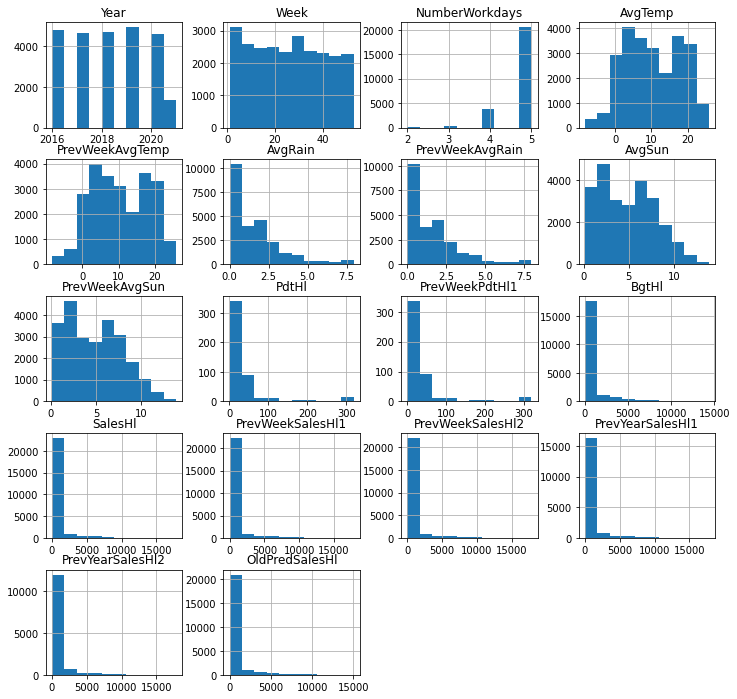

In [771]:
data.hist(figsize=[12,12])
plt.show()

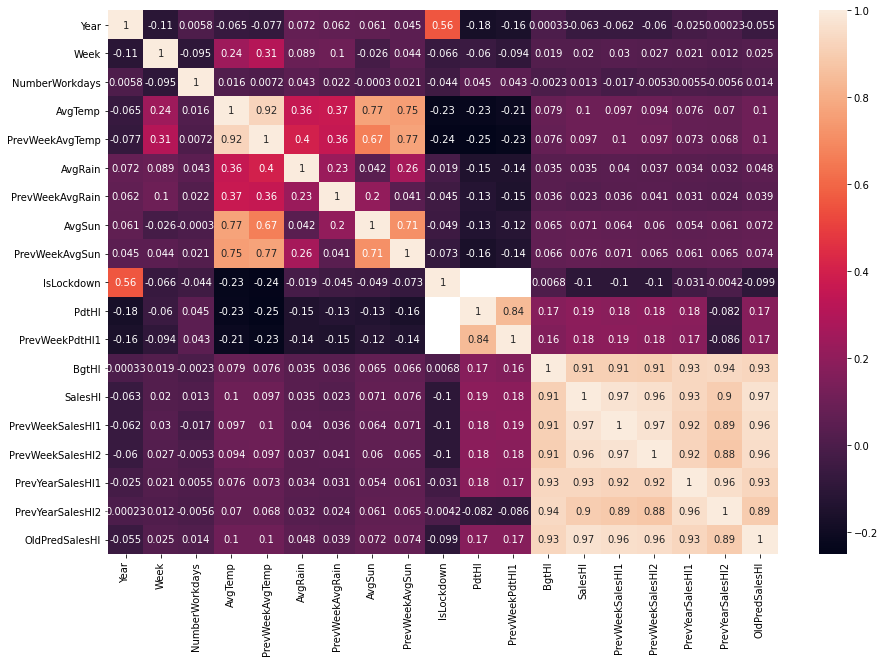

In [772]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

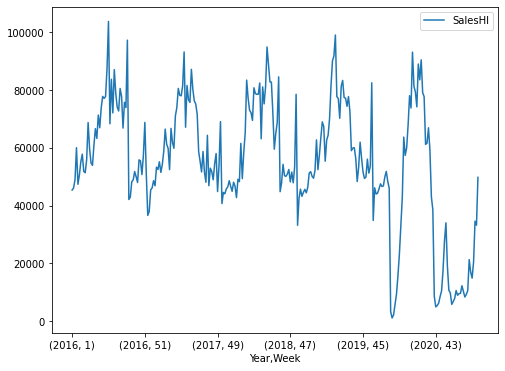

In [773]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

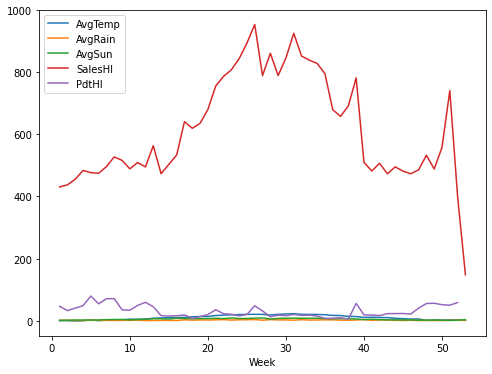

In [774]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

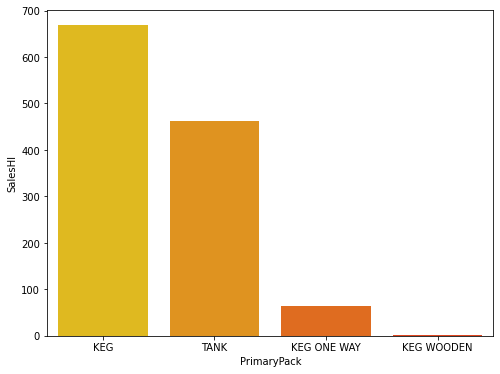

In [775]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

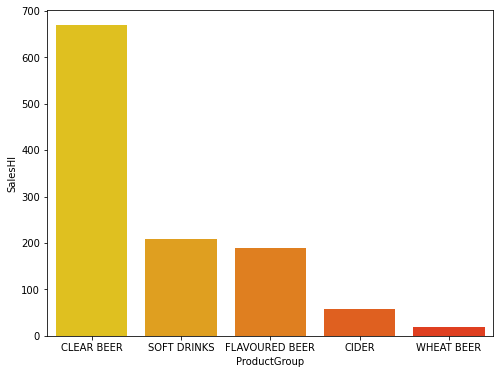

In [776]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [777]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
PrevWeekSalesHl1,0.972611
OldPredSalesHl,0.970593
PrevWeekSalesHl2,0.963891
PrevYearSalesHl1,0.933978
BgtHl,0.908411
PrevYearSalesHl2,0.901446
PdtHl,0.191080
PrevWeekPdtHl1,0.184820
AvgTemp,0.100092


## Skewness and Kurtesis

In [778]:
data.skew()

SkuShort            1.862407
Year                0.082610
Week                0.063349
NumberWorkdays     -2.652512
AvgTemp            -inf     
PrevWeekAvgTemp    -inf     
AvgRain             inf     
PrevWeekAvgRain     inf     
AvgSun              inf     
PrevWeekAvgSun      inf     
IsLockdown          2.309615
PdtHl               3.574219
PrevWeekPdtHl1      3.556641
BgtHl               inf     
SalesHl             4.327397
PrevWeekSalesHl1    inf     
PrevWeekSalesHl2    inf     
PrevYearSalesHl1    inf     
PrevYearSalesHl2    inf     
OldPredSalesHl      inf     
dtype: float64

In [779]:
data.kurt()

SkuShort            4.532806 
Year               -1.138291 
Week               -1.199664 
NumberWorkdays      8.131456 
AvgTemp            NaN       
PrevWeekAvgTemp    NaN       
AvgRain            NaN       
PrevWeekAvgRain    NaN       
AvgSun             NaN       
PrevWeekAvgSun     NaN       
IsLockdown          3.334588 
PdtHl              NaN       
PrevWeekPdtHl1     NaN       
BgtHl              NaN       
SalesHl             21.663244
PrevWeekSalesHl1   NaN       
PrevWeekSalesHl2   NaN       
PrevYearSalesHl1   NaN       
PrevYearSalesHl2   NaN       
OldPredSalesHl     NaN       
dtype: float64

## Create X, y

In [780]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'ProductGroup', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' 'BgtHl',

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [781]:
# X['NextWeek'] = X['Week']+1
# X['PrevWeek'] = X['Week']-1

# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

# X = X.drop(['NextWeek', 'PrevWeek', 'WeekPrev', 'WeekNext'], axis=1)
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
# X

## LabelEncoder

In [782]:
# create Temp
# bins = [-np.inf, -1, 1, 10, 15, 20, np.inf]
# names = ['mraz', 'kolem nuly', 'chladno', 'teplo', 'velmi teplo', 'horko']
# X['Temp'] = pd.cut(X['AvgTemp'], bins=bins, labels=names)
# X['PrevWeekTemp'] = pd.cut(X['PrevWeekAvgTemp'], bins=bins, labels=names)

# #create Rain
# bins = [0, 0.1, 2.5, 8, 40, np.inf]
# names = ['velmi slabá', 'slabá', 'mírná', 'silná', 'velmi silná']
# X['Rain'] = pd.cut(X['AvgRain'], bins=bins, labels=names)
# X['PrevWeekRain'] = pd.cut(X['PrevWeekAvgRain'], bins=bins, labels=names)

# #create Sun
# bins = [0, 2, 5, 8, np.inf]
# names = ['zatazeno', 'oblacno', 'polojasno', 'jasno']
# X['Sun'] = pd.cut(X['AvgSun'], bins=bins, labels=names)
# X['PrevWeekSun'] = pd.cut(X['PrevWeekAvgSun'], bins=bins, labels=names)

# X.Rain = LabelEncoder().fit_transform(X.Rain)
# X.Temp = LabelEncoder().fit_transform(X.Temp)
# X.Sun = LabelEncoder().fit_transform(X.Sun)
# X.PrevWeekTemp = LabelEncoder().fit_transform(X.PrevWeekTemp)
# X.PrevWeekRain = LabelEncoder().fit_transform(X.PrevWeekRain)
# X.PrevWeekSun = LabelEncoder().fit_transform(X.PrevWeekSun)

# X = X.drop(['AvgTemp', 'AvgRain', 'AvgSun', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'], axis=1)

#round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [783]:
Country_mapping = {"CZ": 1, "SK": 2}
PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

el = LabelEncoder()
X.SkuShort = el.fit_transform(X.SkuShort)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,5,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1902.00000,NaN,NaN,NaN,NaN
1,1,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,473.00000,NaN,NaN,NaN,NaN
2,2,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,3010.00000,NaN,NaN,NaN,NaN
3,3,2,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,4932.00000,NaN,NaN,NaN,NaN
4,5,7,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,46.15625,NaN,NaN,NaN,NaN


## Imputer

In [784]:
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [785]:
si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [786]:
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [787]:
# X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]:0.0f}-W{x[1]:0.0f}-1', "%Y-W%W-%w"), axis=1)
# X.Date = X.Date.map(datetime.datetime.toordinal)

#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['SalesPerPdt'] = X['PrevWeekSalesHl1'].divide(X['PrevWeekPdtHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPdt'] = X['SalesPerPdt'].replace([np.inf, -np.inf, np.nan], 0)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,5.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
1,1.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
2,2.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
3,3.0,2.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,4932.00000,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
4,5.0,7.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,46.15625,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9


In [788]:
X.tail()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
24997,84.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,757.499287,637.128357,641.787079,736.633447,783.862332,639.5,760.2,699.9
24998,86.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,34.343750,13.500000,11.398438,2.099609,16.953125,12.4,9.5,11.0
24999,102.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,72.125000,28.656250,21.296875,9.898438,24.593750,25.0,17.2,21.1
25000,103.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,757.499287,259.500000,180.250000,60.000000,289.250000,219.9,174.6,197.2
25001,118.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.0,0.0,360.750000,243.000000,160.500000,87.000000,284.000000,201.8,185.5,193.6


## Split train, test

In [789]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

X = X.drop(['SkuShort'], axis=1) #,'PrimaryPack', 'Country', 'Year'
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

## Scaler

In [790]:
#scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
scaler = StandardScaler()
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)  

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressors

In [791]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

## Find best params

In [792]:
# param_grid = dict(learning_rate=[0.05], max_iter=[100], max_leaf_nodes=[140, 150, 160], min_samples_leaf=[25])
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [793]:
# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))

## Models

### HistGradientBoostingRegressor 

In [794]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [795]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [796]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=4)

### XGBRegressor

In [797]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=4)

### CatBoostRegressor

In [798]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [799]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=4)

### ExtraTreesRegressor

In [800]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [801]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, xgbModel, etrModel]
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=4, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=4,
                       oob_score=True, random_state=0),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=0.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsam

In [802]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 2min 6s


In [803]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models.sort_values(by=['Score'], ascending=False)


#off-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 6	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 0	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 9	GradientBoostingRegressor	0.843769	391493.638902	391493.638902	264.494670	0.84
# 4	MLPRegressor	0.839527	402124.902408	402124.902408	278.039271	0.84
# 12	LinearRegression	0.832977	418538.501574	418538.501574	308.129606	0.83
# 5	Lasso	0.832871	418803.072085	418803.072085	307.357371	0.83
# 7	ARDRegression	0.832818	418936.806781	418936.806781	307.672709	0.83
# 8	BayesianRidge	0.832793	418999.803428	418999.803428	308.173667	0.83
# 11	LinearSVR	0.829922	426193.915922	426193.915922	270.611320	0.83
# 10	KNeighborsRegressor	0.805067	488476.376995	488476.376995	305.001409	0.81
# 1	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8639

# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 3	GradientBoostingRegressor	0.844420	389862.886930	389862.886930	264.334610	0.84
# 0.8668


# 	Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 4	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8658

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.877972	4499.615238	305751.570936	243.381841	0.88
# 1	CatBoostRegressor	0.868797	4848.307931	328742.181746	254.856241	0.87
# 3	RandomForestRegressor	0.866066	4634.582000	335582.718416	245.259708	0.87
# 2	HistGradientBoostingRegressor	0.859194	4445.449309	352803.126808	255.968944	0.86
# 4	XGBRegressor	0.846541	5841.459961	384504.761200	266.124551	0.85
#0.8755

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.868797	4848.307931	328742.181746	254.856241	0.87
# 2	HistGradientBoostingRegressor	0.864450	4511.453271	339633.416764	250.393009	0.86
# 3	RandomForestRegressor	0.862192	5083.518837	345290.029548	243.229869	0.86
# 0	LGBMRegressor	0.859358	5338.457233	352391.703972	257.935003	0.86
# 4	XGBRegressor	0.846541	5841.459961	384504.761200	266.124551	0.85
# 0.8735

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.876750	4573.816964	308813.474901	242.787151	0.88
# 2	HistGradientBoostingRegressor	0.865286	4480.964982	337538.455249	247.344246	0.87
# 3	RandomForestRegressor	0.863139	4935.878258	342917.150870	242.075721	0.86
# 1	CatBoostRegressor	0.862816	5980.891816	343726.206302	256.970952	0.86
# 5	ExtraTreesRegressor	0.856400	5185.426762	359802.457086	254.222853	0.86
# 4	XGBRegressor	0.848221	5599.989258	380296.917207	264.753144	0.85
# 6	HuberRegressor	0.842212	5884.212939	395352.843826	269.894448	0.84
#0.8778


# 	Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.876750	4573.816964	308813.474901	242.787151	0.88
# 2	HistGradientBoostingRegressor	0.865286	4480.964982	337538.455249	247.344246	0.87
# 3	RandomForestRegressor	0.863139	4935.878258	342917.150870	242.075721	0.86
# 1	CatBoostRegressor	0.862816	5980.891816	343726.206302	256.970952	0.86
# 4	ExtraTreesRegressor	0.854816	4920.532056	363770.800687	256.005848	0.85
# 0.8760

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.881453	4476.110411	297031.174702	247.456136	0.88
# 2	HistGradientBoostingRegressor	0.870817	4444.321330	323679.379881	247.669848	0.87
# 1	CatBoostRegressor	0.865533	5666.760007	336919.717836	257.028054	0.87
# 3	RandomForestRegressor	0.863930	4936.985496	340935.891273	242.156392	0.86
# 5	ExtraTreesRegressor	0.859392	4718.446746	352306.400799	256.133988	0.86
# 4	XGBRegressor	0.843604	5721.456055	391864.071047	268.586562	0.84
# 0.8766, 4140.0000

#on-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 6	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 0	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 9	GradientBoostingRegressor	0.842605	67122.924254	67122.924254	106.539311	0.84
# 10	KNeighborsRegressor	0.815448	78704.180046	78704.180046	135.666990	0.82
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 12	LinearRegression	0.811924	80207.259648	80207.259648	170.711040	0.81
# 5	Lasso	0.810957	80619.289766	80619.289766	169.174454	0.81
# 7	ARDRegression	0.810064	81000.421378	81000.421378	170.797118	0.81
# 8	BayesianRidge	0.808762	81555.376370	81555.376370	171.263265	0.81
# 11	LinearSVR	0.791987	88709.547162	88709.547162	123.906669	0.79
# 4	MLPRegressor	0.599296	170884.695195	170884.695195	177.887054	0.60
# 0.8598


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	GradientBoostingRegressor	0.834394	70624.630360	70624.630360	107.111241	0.83
# 0.8747


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 0.8717


# 	Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 4	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
#0.8798

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.886093	1951.314928	48567.852765	97.326672	0.89
# 2	HistGradientBoostingRegressor	0.869292	2951.192139	55731.458495	89.914484	0.87
# 0	LGBMRegressor	0.838248	3581.780052	68968.260265	98.742636	0.84
# 4	XGBRegressor	0.820312	2580.676025	76615.703155	115.247313	0.82
# 3	RandomForestRegressor
# 0.860

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.886093	1951.314928	48567.852765	97.326672	0.89
# 2	HistGradientBoostingRegressor	0.878109	2105.323827	51972.169158	95.063952	0.88
# 0	LGBMRegressor	0.875615	3169.248731	53035.397007	93.709183	0.88
# 3	RandomForestRegressor	0.842970	3282.521439	66954.547602	93.920232	0.84
# 4	XGBRegressor	0.820312	2580.676025	76615.703155	115.247313	0.82
# 0.8798


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.883171	2157.891877	49813.626724	104.215533	0.88
# 0	LGBMRegressor	0.878800	3029.242877	51677.636250	94.861470	0.88
# 2	HistGradientBoostingRegressor	0.872957	2470.649197	54168.848480	95.944487	0.87
# 3	RandomForestRegressor	0.844283	3215.982887	66394.954947	93.763728	0.84
# 5	ExtraTreesRegressor	0.827780	3833.764742	73431.584507	94.676410	0.83
# 4	XGBRegressor	0.812619	2468.038574	79895.776510	114.346503	0.81
# 6	HuberRegressor	0.798678	2931.472186	85840.170854	120.555470	0.80
# 0.8675


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.883171	2157.891877	49813.626724	104.215533	0.88
# 0	LGBMRegressor	0.878800	3029.242877	51677.636250	94.861470	0.88
# 2	HistGradientBoostingRegressor	0.872957	2470.649197	54168.848480	95.944487	0.87
# 3	RandomForestRegressor	0.844283	3215.982887	66394.954947	93.763728	0.84
# 4	ExtraTreesRegressor	0.837165	3755.308623	69429.831443	92.372810	0.84
# 0.8731, 3007.0000


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.897287	1913.845427	43794.754659	94.319321	0.90
# 0	LGBMRegressor	0.887499	3183.665807	47968.436237	86.968840	0.89
# 2	HistGradientBoostingRegressor	0.882464	2419.912469	50115.002449	93.875961	0.88
# 3	RandomForestRegressor	0.844800	3261.584169	66174.599554	93.106406	0.84
# 4	XGBRegressor	0.834410	3122.962891	70604.492375	111.953248	0.83
# 5	ExtraTreesRegressor	0.824119	4149.834659	74992.264525	92.845915	0.82
# 0.8755, 2938.0000

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.906500	1620.536292	39866.571585	91.589080	0.91
# 2	HistGradientBoostingRegressor	0.880496	2233.264712	50954.193725	94.697780	0.88
# 0	LGBMRegressor	0.861194	3443.464711	59184.455358	95.829477	0.86
# 4	XGBRegressor	0.846052	3321.312500	65640.444875	109.056269	0.85
# 3	RandomForestRegressor	0.844228	3254.442526	66418.462063	93.688319	0.84
# 5	ExtraTreesRegressor	0.826406	3869.360925	74017.349860	94.686626	0.83
# 0.8735, 2963.0000


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.886093	1951.314928	48567.852765	97.326672	0.89
# 2	HistGradientBoostingRegressor	0.878109	2105.323827	51972.169158	95.063952	0.88
# 0	LGBMRegressor	0.867987	3060.219495	56288.079762	93.129330	0.87
# 3	RandomForestRegressor	0.842970	3282.521439	66954.547602	93.920232	0.84
# 5	ExtraTreesRegressor	0.832147	3796.008042	71569.344861	92.839672	0.83
# 4	XGBRegressor	0.820312	2580.676025	76615.703155	115.247313	0.82
# 0.8715, 2756.0000

,Model,Score,ME,MSE,MAE,Weights
1,CatBoostRegressor,0.900878,2020.100794,42263.836724,95.049952,0.90
0,LGBMRegressor,0.885860,2785.588148,48667.093658,91.878633,0.89
2,HistGradientBoostingRegressor,0.859701,2133.203337,59821.024110,99.122813,0.86
3,RandomForestRegressor,0.845290,3117.859039,65965.543155,93.737211,0.85
4,XGBRegressor,0.818533,3293.611816,77374.347664,112.707420,0.82
5,ExtraTreesRegressor,0.814872,4201.596458,78934.958691,94.937546,0.81


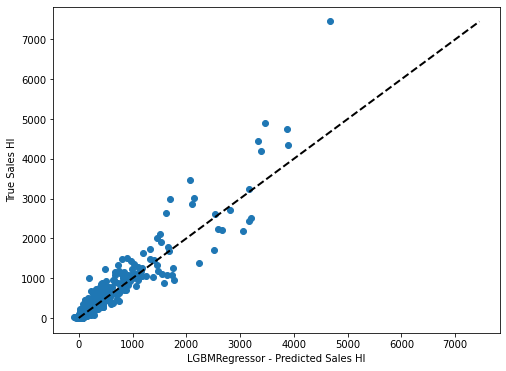

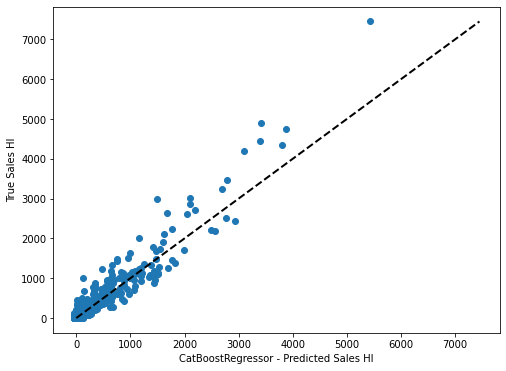

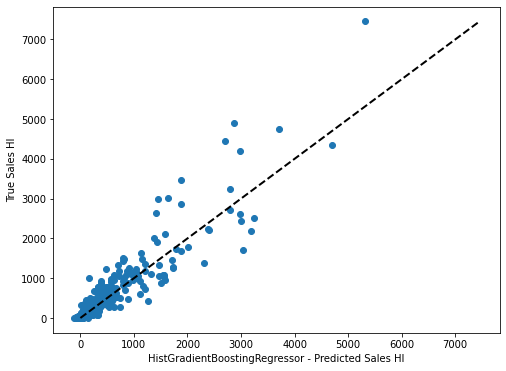

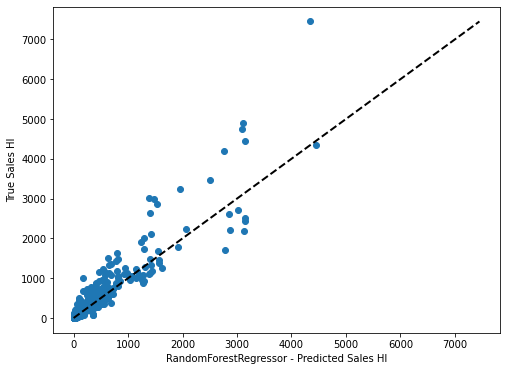

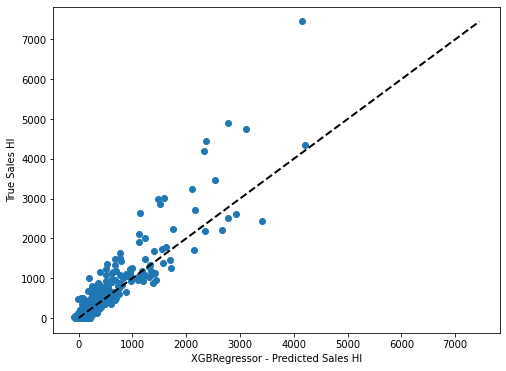

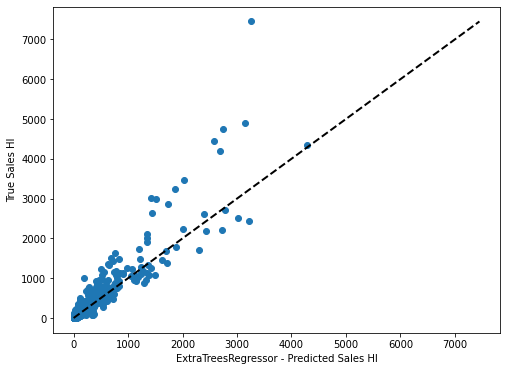

In [804]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

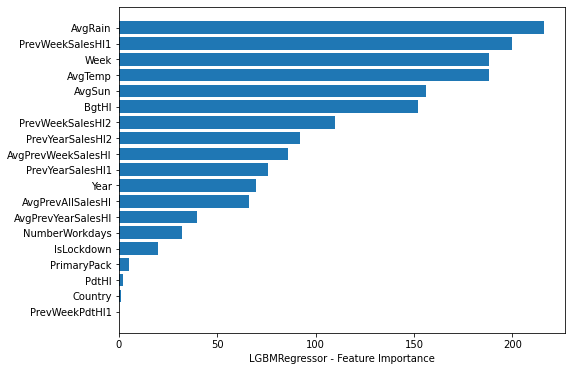

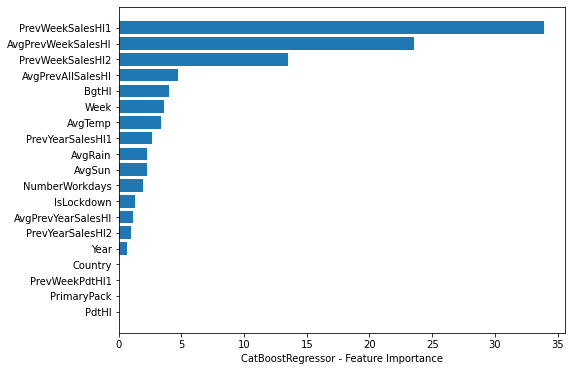

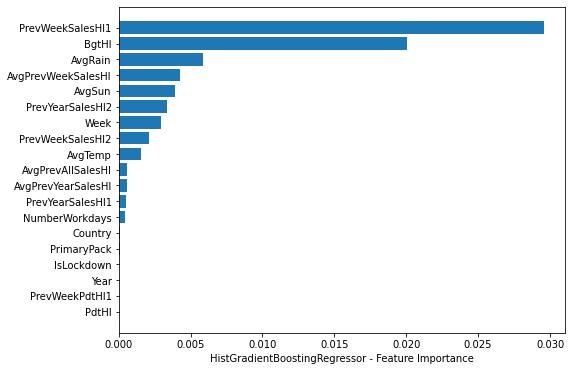

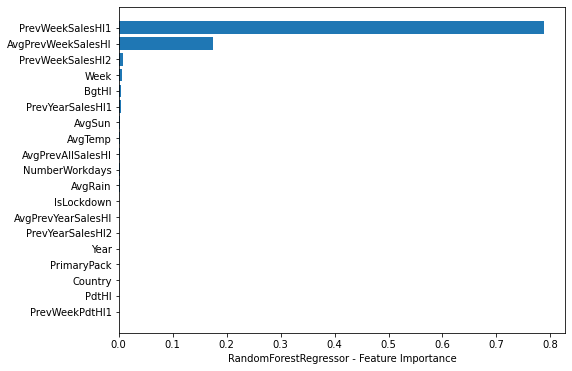

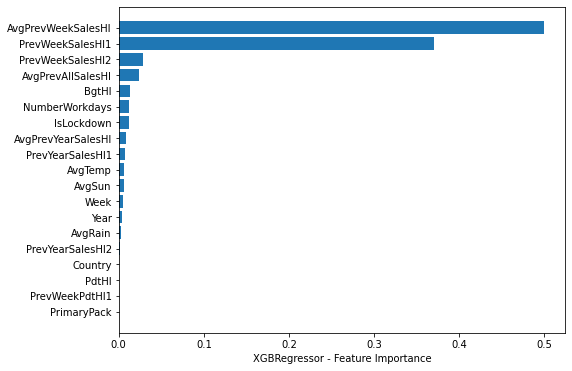

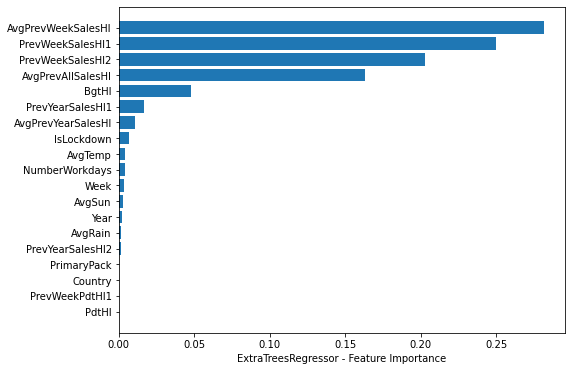

In [805]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [806]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))

on-trade
Coefficient of determination: 0.8710
Maximum residual error: 2831.0000
Mean absolute percentage error regression loss: 4045295730419631.5000
Old Coefficient of determination: 0.8996
Old Maximum residual error: 1992.0000
Mean absolute percentage error regression loss: 366643117560692.1875
Wall time: 1min 51s


## Model analysis

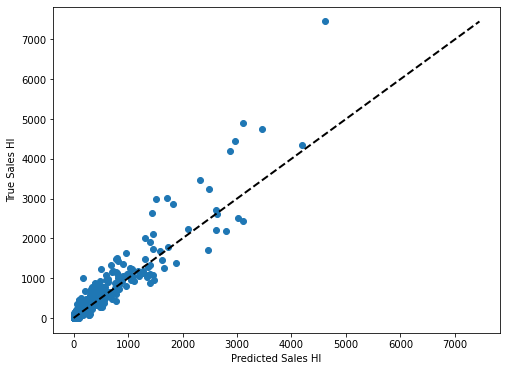

In [807]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

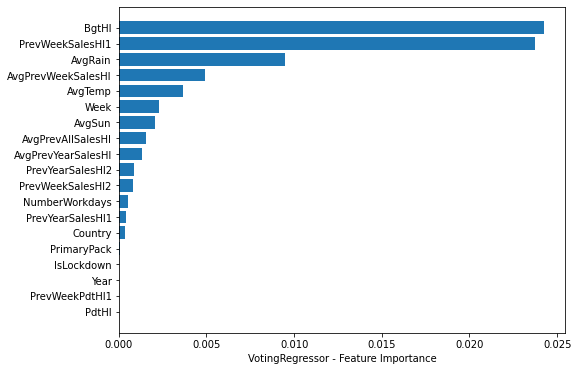

Wall time: 50.2 s


In [808]:
%%time

show_feature_importances(model, X_test, y_test)

In [809]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10    99.2%          82.8%          -16.4%           
     11    92.7%          91.9%          -0.7%            
     12    93.5%          93.2%          -0.3%            
     13    57.3%          48.2%          -9.1%            
     14    64.8%          89.1%          24.3%            
     15    86.0%          87.5%          1.5%             
     16    99.3%          78.2%          -21.2%           
     17    94.0%          61.8%          -32.2%           
     18    81.9%          96.6%          14.8%            
     19    73.4%          76.5%          3.1%             
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021  82.6%          83.1%          0.5%             


In [810]:
X_labels =  X.columns

# examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=0), pd.DataFrame(X_test).sample(n=700)]).to_numpy()
examples_numpy = X_test

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

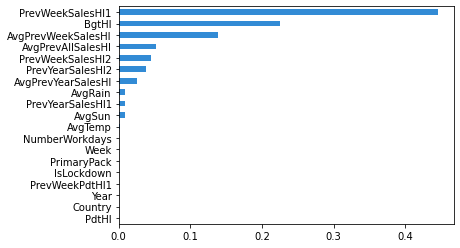

In [811]:
name ,model = estimators[0]


# examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=0), pd.DataFrame(X_test).sample(n=700)]).to_numpy()
examples_numpy = X_test.to_numpy()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

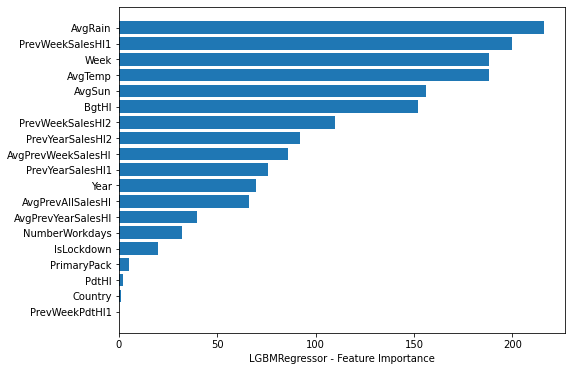

In [812]:
show_feature_importances(model, X_test, y_test)

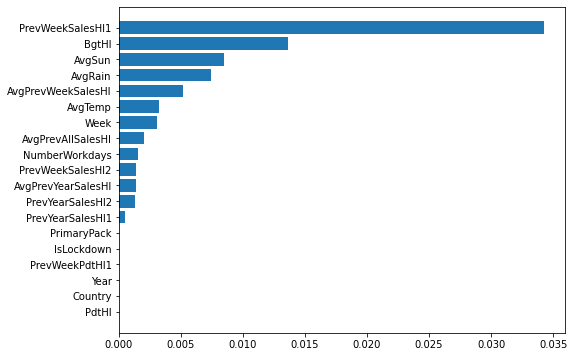

In [813]:
r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=4)
importances = r.importances_std

sorted_idx = importances.argsort()

plt.figure(figsize=(8,6)) 
plt.barh(X_labels[sorted_idx], importances[sorted_idx])
plt.show()

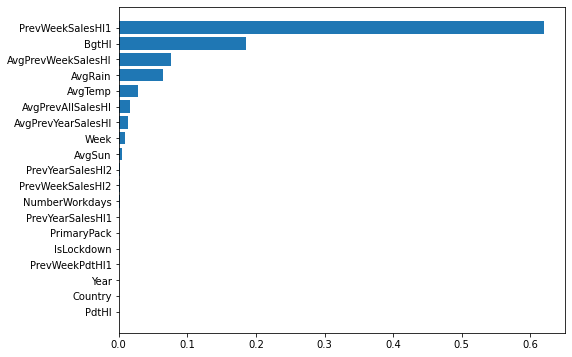

In [814]:


perm = PermutationImportance(model, cv = None, refit = False, n_iter = 50).fit(X_test, y_test)
sorted_idx = perm.feature_importances_.argsort()

plt.figure(figsize=(8,6)) 
plt.barh(X_labels[sorted_idx], perm.feature_importances_[sorted_idx])
plt.show()

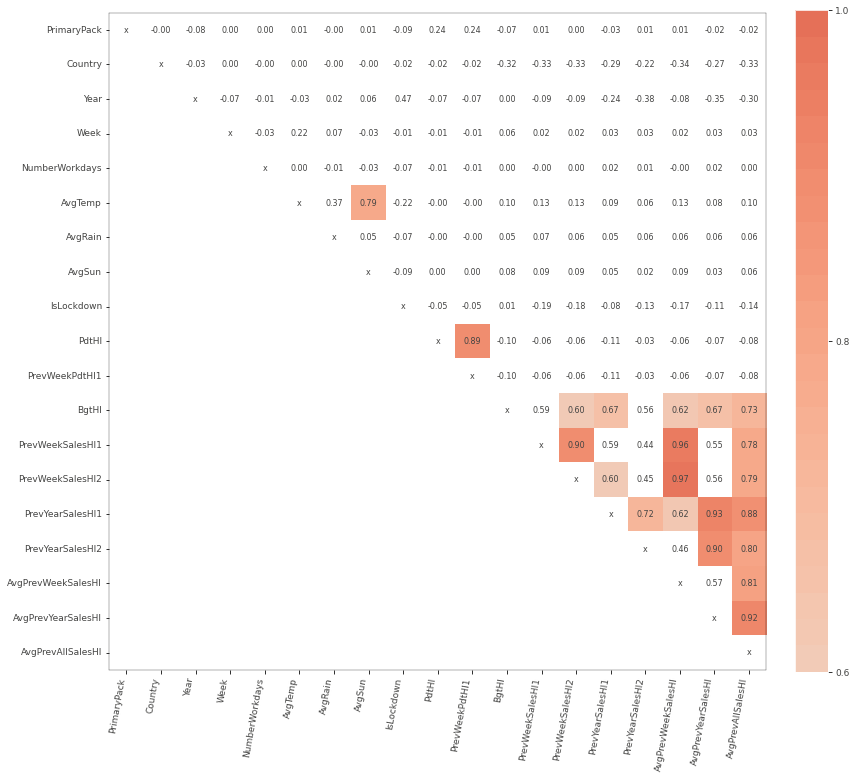

In [815]:


def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

# perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
viz = plot_corr_heatmap(X_train, figsize=(12,12))
viz.view()

In [816]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [817]:


# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

C extension was not built during install!
C extension was not built during install!


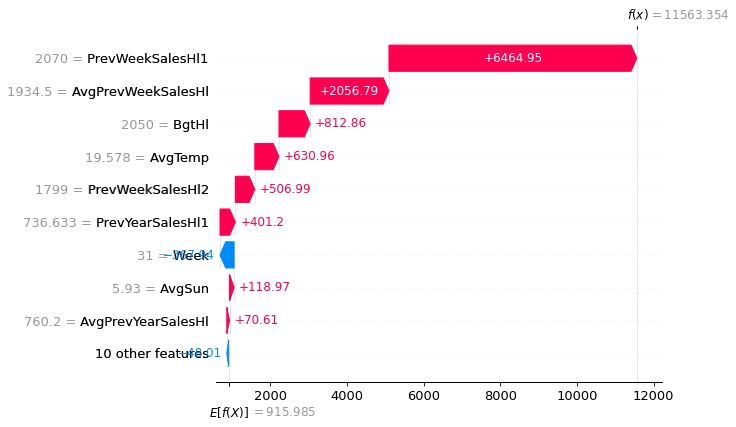

In [818]:
shap.initjs()

X100 = shap.utils.sample(X, 100)

explainer = shap.Explainer(model)
shap_values = explainer(X100)

shap.plots.waterfall(shap_values[0])

In [819]:
# shap.plots.force(shap_values[0])

In [820]:
# shap.plots.force(shap_values)

In [821]:
# shap.plots.scatter(shap_values, color=shap_values)

In [822]:
# shap.plots.bar(shap_values)

In [823]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [824]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [825]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [826]:

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363